<a href="https://colab.research.google.com/github/oughtinc/ergo/blob/master/notebooks/build/el-paso-workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [7]:
%%capture
!pip install --progress-bar off poetry
!pip install --progress-bar off git+https://github.com/oughtinc/ergo.git@8578059fa41f9ba217dff90fa323a35842d5e033

In [1]:
import warnings
import ssl
warnings.filterwarnings(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="plotnine")
ssl._create_default_https_context = ssl._create_unverified_context

In [32]:
import ergo
import seaborn

import numpy as np
import pandas as pd
from datetime import timedelta, date
import matplotlib.pyplot as plt

pd.set_option('precision', 2)

def summarize_samples(samples):
    stats = samples.describe(percentiles=[0.05, 0.5, 0.95])
    percentile = lambda pt: float(stats.loc[f"{pt}%"])
    return f"{percentile(50):.2f} ({percentile(5):.2f} to {percentile(95):.2f})"

def show_marginal(func):
    samples = ergo.run(func, num_samples=1000)
    seaborn.distplot(samples["output"]).set_title(func.__doc__);
    plt.show()
    print(f"Median {func.__doc__}: {summarize_samples(samples['output'])}")

# Choose a decision-relevant question

## How many ventilators will be needed in El Paso?

I want to predict on this question:

> How many ventilators will be needed for COVID patients in El Paso county in May? (On the day when the most ventilators are needed, how many will be needed?)

Background:

- El Paso is a county in Texas (population 850,000) that is dealing with the impacts of COVID-19.
- The prediction site [Metaculus](https://www.metaculus.com) partnered with administrators at Texas Tech University Health Sciences Center to predict on questions that will guide decision making there.
- This question is particularly decision-relevant: it's crucial to have enough ventilators for the patients who need them.

## Loading question data from the Metaculus crowd prediction platform

Ergo can load questions and make predictions on Metaculus, Foretold, and other crowd prediction sites.

I'll load [the relevant question](https://pandemic.metaculus.com/questions/4204)* from Metaculus:

In [3]:
metaculus = ergo.Metaculus(username="oughtpublic", password="123456", api_domain="pandemic")
ventilators_question = metaculus.get_question(4201, name="# ventilators needed")
ventilators_question

<MetaculusQuestion name="# ventilators needed">

\**Note: We're not asking exactly the same question as the Metaculus question. Most importantly, the Metaculus question is asking for the number of ventilators needed on a "peak hospitalizations" day that's defined in a complex way. To make things simpler, 
we're just asking how many ventilators are needed on the day when the most ventilators are needed.*

# A guess

I'll start by making an uninformed guess. I'll do this before I look at any data or anyone else's predictions. That way, I can look back to this guess to see what I learn as I go through the forecasting process.

What is my 90% confidence interval for the number of ventilators needed? I think there is a 

- less than 5% chance that <3 people will require ventilation
- less than 5% chance that >100 people will require ventilation

So I'll go with a 90% confidence interval of [3, 100].

I don't know much about El Paso, ICUs, or ventilators. I feel pretty uncertain and assign non-negligible probability to higher values. I'll go with a [lognormal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution), which will assign more probability to the "long tail" of higher values than would a normal distribution.

## Distributions in Ergo

In Ergo, I can generate a single sample from this distribution like this:

In [4]:
ergo.lognormal_from_interval(3, 100)

DeviceArray(20.191326, dtype=float32)

To get many samples, I use `ergo.run`:

In [5]:
def ventilators_needed():
    "# ventilators needed"
    return ergo.lognormal_from_interval(3, 100)

samples = ergo.run(ventilators_needed, num_samples=1000)

samples

,output
0,91.75
1,4.04
2,21.08
3,82.26
4,49.40
...,...
995,14.95
996,10.95
997,6.60
998,7.30


Why sample instead of manipulating distributions directly?

As I build out my model, we'll see that: 

- Composing samplers is easy - it's just programming as usual
- Composing probability distributions is hard - it's math

I'll build up complex models by composing samplers.

## Visualizing distributions

I can visualize these samples using my question's `show_prediction` method:

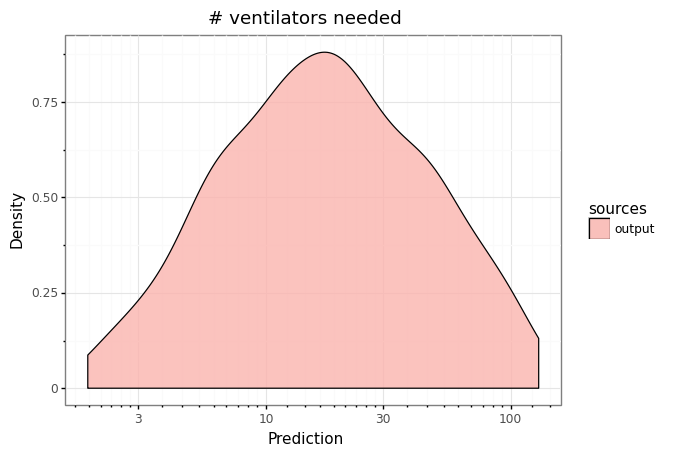

In [6]:
ventilators_question.show_prediction(samples)

# Model V1: My guess

I'll wrap my guess in a `Model` class so that I can more easily build on it step by step by inheriting from the class, adding more methods, and replacing methods with better implementations:

In [7]:
class ModelV1:
    
    def ventilators_needed(self):
        "# ventilators needed"
        return ergo.lognormal_from_interval(3, 100)

    def run(self):
        samples = ergo.run(self.ventilators_needed, num_samples=1000)
        ventilators_question.show_prediction(samples["output"]); plt.show()
        print(f"Median estimate of # ventilators needed: {summarize_samples(samples['output'])}")

This doesn't change the result:

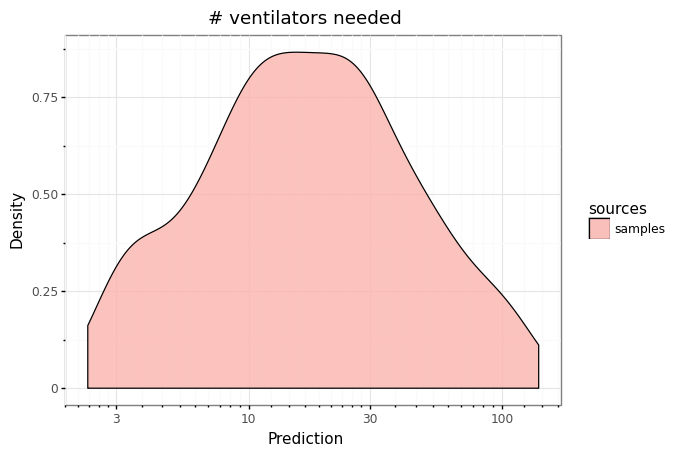

Median estimate of # ventilators needed: 16.87 (2.91 to 102.11)


In [8]:
ModelV1().run()

It's still an uninformed guess.

# Model V2: Decompose ventilators needed

## My decomposition

My strategy for this question will be to break it into pieces and then improve my estimate for each piece.

To estimate the maximum number of ventilators needed, I'll multiply the answers to:

1. What's the maximum number of patients who will be in the ICU at once?
2. What fraction of those patients will be on ventilators?

So my decomposition looks like this:

- \# ventilators needed =
  - max # icu patients *
  - % of icu patients ventilated
 
For both of these I'll make pretty uninformed guesses for now:

1. I guess that about 5 to 200 people will be the maximum number of people in the ICU (but I have no idea)
2. I'd guess that 1 out of 3 will need ventilators (but I have no idea)

For ICU cases, I use the same `lognormal_from_interval` function I used above. I'll always show components of my model in blue and the overall model prediction in red:

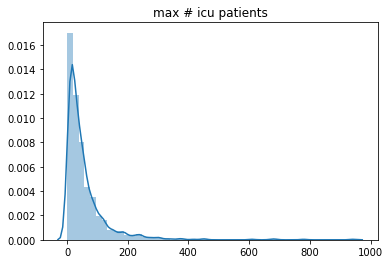

Median max # icu patients: 35.34 (5.51 to 188.67)


In [9]:
def max_icu_patients():
    "max # icu patients"
    return ergo.lognormal_from_interval(5, 200)

show_marginal(max_icu_patients)

For ventilation need, I'll use a [beta-binomial distribution](http://varianceexplained.org/statistics/beta_distribution_and_baseball/):

In [10]:
def frac_icu_ventilated():
    "% of icu patients ventilated"
    return ergo.beta_from_hits(1, 3)

This distribution looks like this:

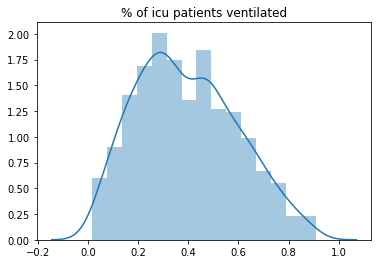

Median % of icu patients ventilated: 0.37 (0.09 to 0.75)


In [11]:
show_marginal(frac_icu_ventilated)

## My new model

My model now looks like this:

In [12]:
class ModelV2(ModelV1):
    
    def ventilators_needed(self):
        "# ventilators needed"
        return self.frac_icu_ventilated() * self.max_icu_patients()   
    
    def max_icu_patients(self):
        "max # of icu patients"
        return ergo.lognormal_from_interval(5, 200)

    def frac_icu_ventilated(self):
        "% of icu patients ventilated"
        return ergo.beta_from_hits(1, 3)

This doesn't change the overall estimate much:

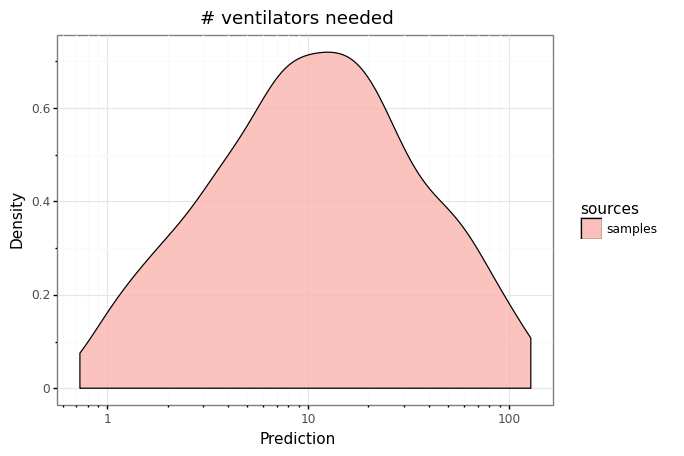

Median estimate of # ventilators needed: 11.12 (1.10 to 94.20)


In [13]:
model_v2 = ModelV2()
model_v2.run()

# Model V3: Use external model for # of ICU patients

So far, I've just made an uninformed guess about the maximum number of patients in the ICU.

I could do more modeling myself to get a more accurate number, but it seems better to just use [this model](https://github.com/shaman-lab/COVID-19Projection)
([paper](https://www.medrxiv.org/content/10.1101/2020.03.21.20040303v2)) from the Shaman lab at Columbia university.*

\**Note: the Columbia model directly makes predictions for how many ventilators will be needed, so it would be most sensible to just use those numbers directly. But, that wouldn't make for a very useful or informative tutorial. So instead, I'll pretend that the ventilator predictions don't exist, and I'll make my own based on the Columbia prediction for number of people in the ICU.*

Our team made an interface to the Columbia projections, which I'll use here.

In [14]:
from ergo.contrib.el_paso import shaman

cu_projections = shaman.load_cu_projections("El Paso County TX")

## My new model

Now I can change my model to use the Columbia projections rather than my guess from before:

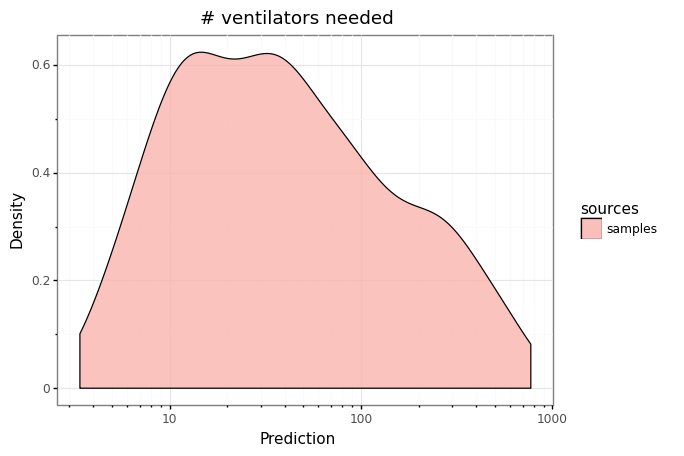

Median estimate of # ventilators needed: 35.14 (4.81 to 503.49)


In [15]:
class ModelV3(ModelV2):
    def max_icu_patients(self):
        "max # of icu patients"
        return max(shaman.cu_projections_for_dates("ICU", date(2020,5,1), date(2020,6,1), cu_projections))

model_v3 = ModelV3()
model_v3.run()

### Why did my model results change?

This makes the tail of # of ventilators needed considerably fatter. I can see that this is because the Columbia model has a much fatter tail for the max number of ICU patients than my previous guess had:

#### 1. My previous guess for max ICU patients

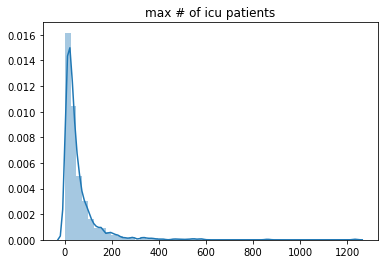

Median max # of icu patients: 33.23 (5.78 to 192.95)


In [16]:
show_marginal(model_v2.max_icu_patients)

#### 2. The Columbia model prediction for max ICU patients

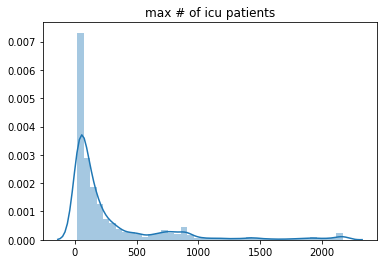

Median max # of icu patients: 108.50 (21.00 to 1317.10)


In [17]:
show_marginal(model_v3.max_icu_patients)

# Model V4: Decompose fraction of ICU patients ventilated

I want to improve my estimate for the fraction of ICU patients ventilated:

- \# ventilators needed =
  - max # icu patients *
  - **% of icu patients ventilated**
  
I can break it down as:
- % of icu patients ventilated =
  - \% icu patients that need ventilation at some point while in the ICU *
  - icu-ventilation adjustment
  
I'll skip guessing these values and just go ahead and use data to model them.

## Fraction of ICU patients that need ventilation at some point during their ICU stay

I'll model this by looking at [data from publications](https://pandemic.metaculus.com/questions/4154/#comment-28155). This is the approach followed by PabloStafforini et al on Metaculus.

In [18]:
def icu_receive_ventilation(self):
    "% icu patients that need ventilation at some point while in the ICU"
    ventilation_pseudocounts = 25 + 17 + 0.05 * 1150 + 0.1 * 132
    icu_pseudocounts = 100 + 36 + 0.05 * 1300 + 0.1 * 196
    return ergo.beta_from_hits(ventilation_pseudocounts, icu_pseudocounts)

## ICU-ventilation adjustment

### Why is this necessary?

It might seem that I could just multiply `max # icu patients * % icu patients that need ventilation at some point while in the ICU` to get `ventilators needed`, but I cannot.

To see this, first imagine that:
1. There are 100 patients in the ICU
2. 1/2 of ICU patients need ventilation at some point during their stay

Then `max # icu patients * % icu patients that need ventilation at some point while in the ICU` = 50.

`max # icu patients * % icu patients that need ventilation at some point while in the ICU` may give too high an estimate of ventilators needed. Imagine that:
1. Patients who will need ventilation at some point during their ICU stay remain in the ICU for the same total amount of time as ICU patients who will never need ventilation
2. ICU patients only need ventilation for 1/2 of their ICU stay

In this scenario, in fact only 1/4 * 100 = 25 ICU patients will need ventilation at any one time.*

\**Note: Alternatively, `max # icu patients * % icu patients that need ventilation at some point while in the ICU` may give an underestimate. Imagine that:*
1. *Patients who will need ventilation at some point during their ICU stay remain in the ICU 10 times as long as ICU patients who will not never need ventilation*
2. *All ICU patients who need ventilation need it for their entire stay*

*The math is a bit more complicated and I haven't done it, but hopefully it's clear that in fact almost all 100 of the patients will need ventilation at any given time.*

### Making the adjustment

My model needs some way to adjust for this complication. My guess is that this parameter won't actually have a huge impact, so I'll just guess that it's fairly close to 1:

In [19]:
def icu_ventilation_adjustment(self):
    return ergo.lognormal_from_interval(0.5, 1.5)

## My new model

### New decomposition
My new overall decomposition is:
- \# ventilators needed =
  - max # icu patients *
  - % of icu patients ventilated
      - \% icu patients that need ventilation at some point while in the ICU *
      - icu-ventilation adjustment

Updating my model with the new decomposition and submodels:

In [36]:
class ModelV4(ModelV3):
    def icu_receive_ventilation(self):
        "% icu patients that need ventilation at some point while in the ICU"
        ventilation_pseudocounts = 25 + 17 + 0.05 * 1150 + 0.1 * 132
        icu_pseudocounts = 100 + 36 + 0.05 * 1300 + 0.1 * 196
        return ergo.beta_from_hits(ventilation_pseudocounts, icu_pseudocounts)
    
    def icu_ventilation_adjustment(self):
        "adjustment to the % of icu patients ventilated at some point to get the % currently ventilated"
        return ergo.lognormal_from_interval(0.5, 1.5)
        
    def frac_icu_ventilated(self):
        "% of icu patients ventilated"
        return self.icu_receive_ventilation() * self.icu_ventilation_adjustment()

model_v4 = ModelV4()

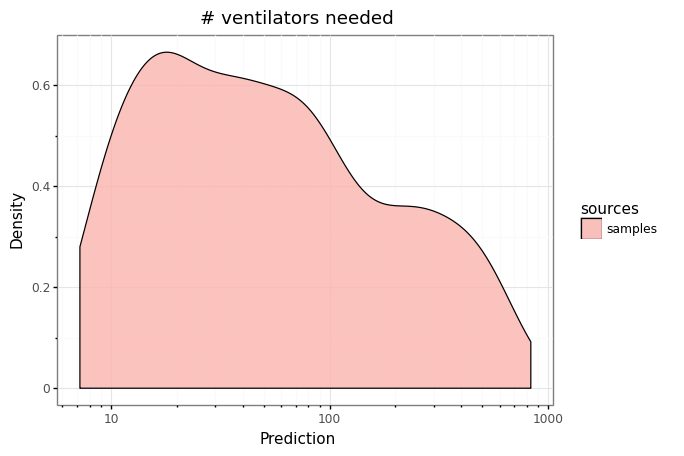

Median estimate of # ventilators needed: 45.25 (8.11 to 550.49)


In [21]:
model_v4.run()

This doesn't change my prediction much.

# Model V5: Ensemble with community prediction

In the previous model, I used a model based on data to predict the proportion of ICU patients that need ventilation at some point during their ICU stay.

However, there's a Metaculus question for [what proportion of hospital patients will be admitted to the ICU](https://pandemic.metaculus.com/questions/4155/what-portion-of-in-hospital-cases-in-el-paso-county-will-require-admission-to-the-icu/), and another one for [what proportion of hospital patients will require ventilation](https://pandemic.metaculus.com/questions/4154/what-portion-of-in-hospital-patients-with-covid-19-in-el-paso-county-will-require-invasive-ventilation/).

If I assume that all ventilated patients are in the ICU, I can do some simple math to get a Metaculus estimate for proportion of ICU patients ventilated:

In [22]:
icu_admit_per_hospital_admit_question = metaculus.get_question(4155)
ventilation_per_hospital_admit = metaculus.get_question(4154)

def metaculus_icu_receive_ventilation():
    """
    The Metaculus community's implicit prediction for 
    % icu patients that need ventilation at some point while in the ICU
    """
    icu_admit_per_hospital_admit_sample = icu_admit_per_hospital_admit_question.sample_community()
    ventilation_per_hospital_admit_sample = ventilation_per_hospital_admit.sample_community()
    
    icu_clipped = max(icu_admit_per_hospital_admit_sample, 0.01)
    ventilated_clipped = max(ventilation_per_hospital_admit_sample, 0.01)
    
    return ventilated_clipped / icu_clipped

Comparing to my model:

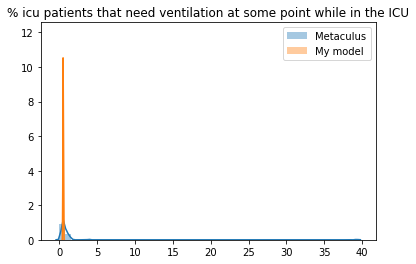

In [23]:
num_samples = 100
metaculus_samples = [metaculus_icu_receive_ventilation() for _ in range(num_samples)]
seaborn.distplot(metaculus_samples)

model_samples = ergo.run(model_v4.icu_receive_ventilation, num_samples=num_samples)
seaborn.distplot(model_samples).set_title(model_v4.icu_receive_ventilation.__doc__)
plt.legend(labels=["Metaculus", "My model"])
plt.show();

The implicit community prediction is similar to my model prediction, but much less confident.

## My new model - now with ensembling!
I can combine my prediction and the community prediction into an ensembled prediction. I'll sample from the metaculus community prediction half the time, and from the Metaculus community prediction half the time.

In [24]:
class ModelV5(ModelV4):
    def my_model_icu_receive_ventilation(self):
        "% icu patients that need ventilation at some point while in the ICU"
        ventilation_pseudocounts = 25 + 17 + 0.05 * 1150 + 0.1 * 132
        icu_pseudocounts = 100 + 36 + 0.05 * 1300 + 0.1 * 196
        return ergo.beta_from_hits(ventilation_pseudocounts, icu_pseudocounts)
    
    def metaculus_icu_receive_ventilation(self):
        """
        The Metaculus community's implicit prediction for 
        % icu patients that need ventilation at some point while in the ICU
        """
        icu_admit_per_hospital_admit_sample = icu_admit_per_hospital_admit_question.sample_community()
        ventilation_per_hospital_admit_sample = ventilation_per_hospital_admit.sample_community()

        icu_clipped = max(icu_admit_per_hospital_admit_sample, 0.01)
        ventilated_clipped = max(ventilation_per_hospital_admit_sample, 0.01)

        return ventilated_clipped / icu_clipped
    
    def icu_receive_ventilation(self):
        "% icu patients that need ventilation at some point while in the ICU"
        # use the community prediction half the time, my model half the time 
        if ergo.flip(0.5):
            return self.metaculus_icu_receive_ventilation()
        else:
            return self.my_model_icu_receive_ventilation()

model_v5 = ModelV5()

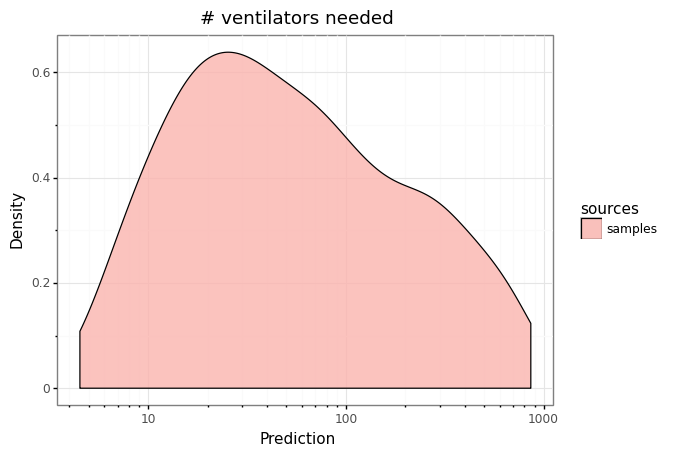

Median estimate of # ventilators needed: 45.79 (6.70 to 665.96)


In [25]:
model_v5.run()

### Marginals

This is my last model, so let's also take a look at all the predictions for its marginals (the steps in the decomposition):

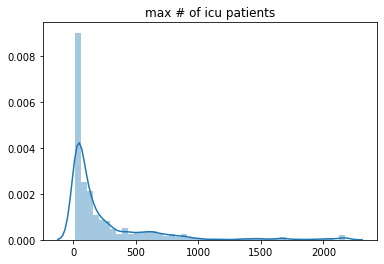

Median max # of icu patients: 95.50 (20.00 to 919.85)


In [27]:
show_marginal(model_v5.max_icu_patients)

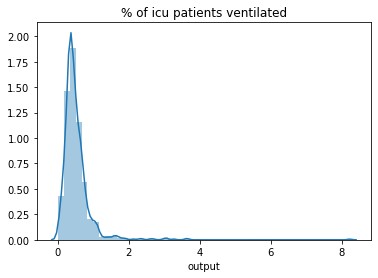

Median % of icu patients ventilated: 0.43 (0.15 to 1.06)


In [33]:
show_marginal(model_v5.frac_icu_ventilated)

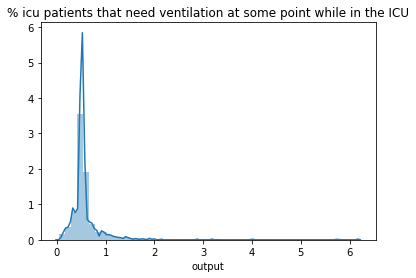

Median % icu patients that need ventilation at some point while in the ICU: 0.51 (0.25 to 1.08)


In [34]:
show_marginal(model_v5.icu_receive_ventilation)

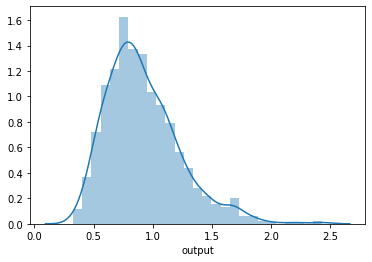

Median None: 0.87 (0.51 to 1.51)


In [35]:
show_marginal(model_v5.icu_ventilation_adjustment)

# Review

My original question was:

> How many ventilators will be needed for COVID patients in El Paso county in May?

We broke it down as follows:

- \# ventilators needed
  - max # icu patients  *
  - % of icu patients ventilated
      - \% icu patients that need ventilation at some point while in the ICU *
      - icu-ventilation adjustment

The final answer and the value for each parameter in the breakdown are given in the graphs above.

# Exercises for the reader

Some questions to help you think through and extend my model:
1. What did I change about the model at each step and how did that affect my prediction? Do you think the change in my prediction is likely to be an improvement?
2. How could I decompose the question further or use better data/submodels to make a better prediction?
  
  a. How could I make a data/model based prediction for `icu-ventilation adjustment` instead of making a guess?
  b. How could I make better use of the Metaculus community predictions to estimate `% icu patients that need ventilation at some point while in the ICU`? Does it make sense to sample from each of the 2 Metaculus questions independently of the other?
3. What assumptions does the model make that might be unwarranted?
  
  a. What does the model assume about the relationship between the number of patients in the ICU on a given day, and the proportion of those patients who need to be ventilated?
4. The final model is currently extremely uncertain.
  
  a. Why?
  b. Is that uncertainty warranted?
  c. How could you reduce it in a reasonable way?